# 2 Time series forecasting with sktime
Estimated time: 40 min

## Agenda

- Quickstart
- Univariate forecasting
    - With statistical models
    - With machine learning models
    - Model evaluation and selection
- Univariate forecasting with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

## Quickstart

* typical business use case :-)
* here's some monthly historic sales data

In [1]:
import warnings 
warnings.filterwarnings("ignore")

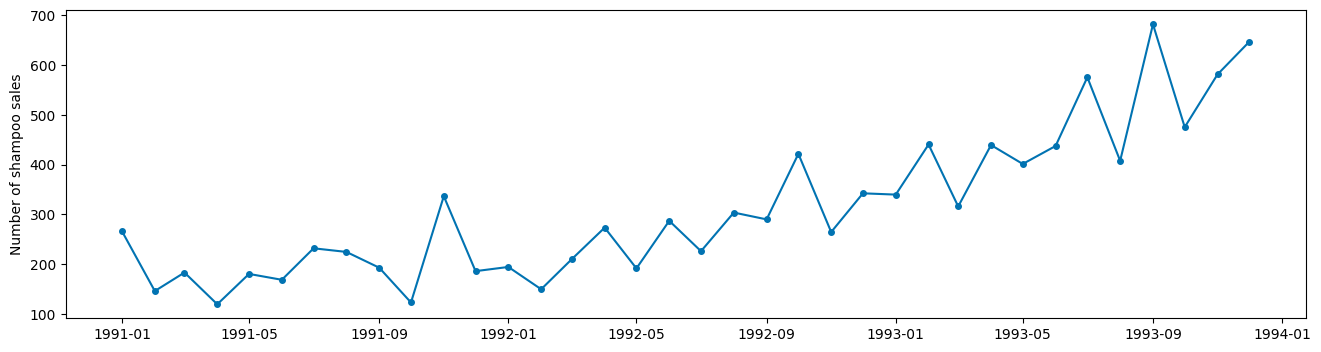

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

fig, ax = plot_series(y)

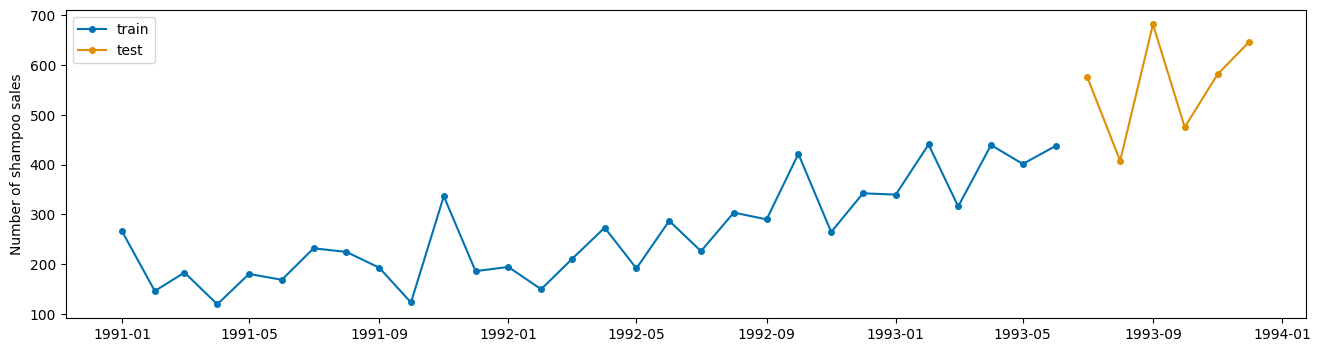

In [3]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

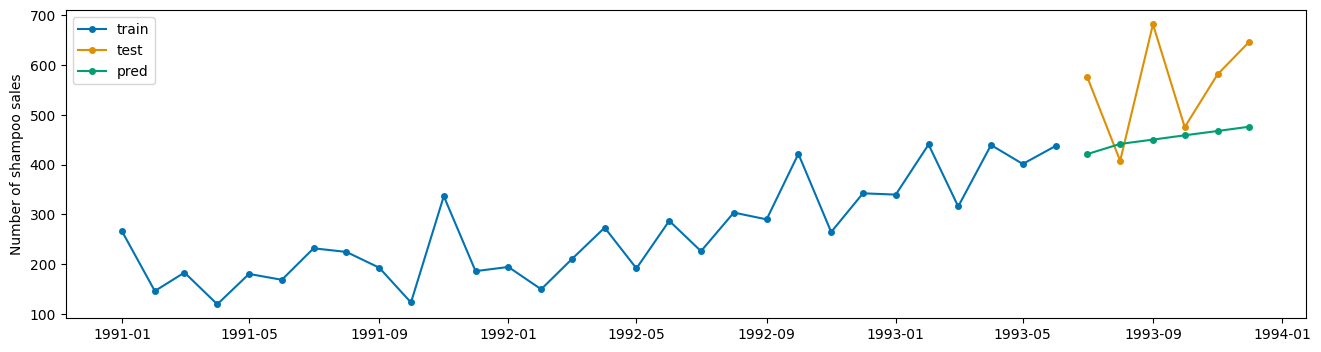

In [4]:
from sktime.forecasting.arima import AutoARIMA

# 1) Define the model
forecaster = AutoARIMA(suppress_warnings=True)

# 2) Fit on train data
fh = [1, 2, 3, 4, 5, 6] # Relative to y_train
forecaster.fit(y_train, fh=fh)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
y_pred = forecaster.predict()

# plot the forecast
fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [5]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoARIMA - sMAPE error: 22.6%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## 2.1 Univariate forecasting

showcase common approaches for forecasting univariate time series in `sktime`:
- Classical statistical models (e.g., econometric, ARIMA, etc)
- Machine learning models (e.g., direct/recursive reduction)

Recommendation: try simple models and naive baselines first!

### Classical forecasting method example: `AutoETS`

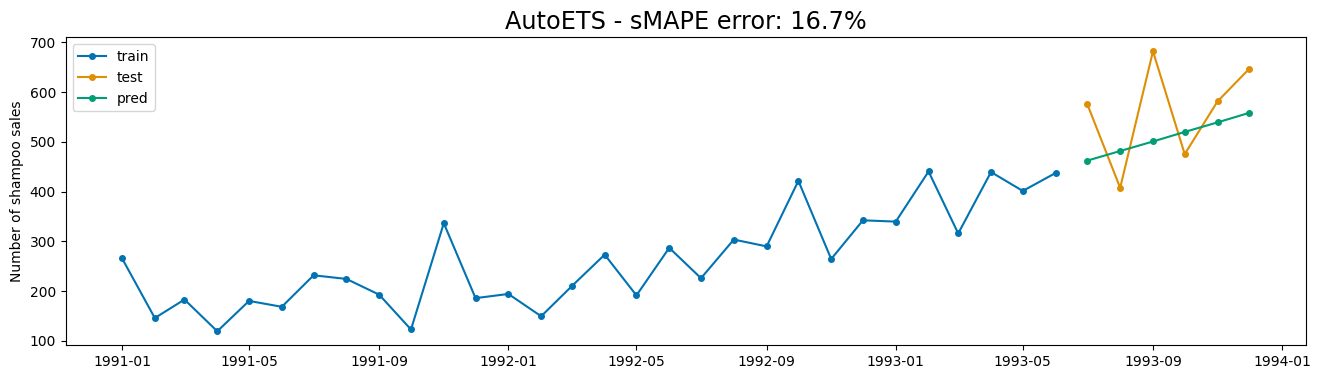

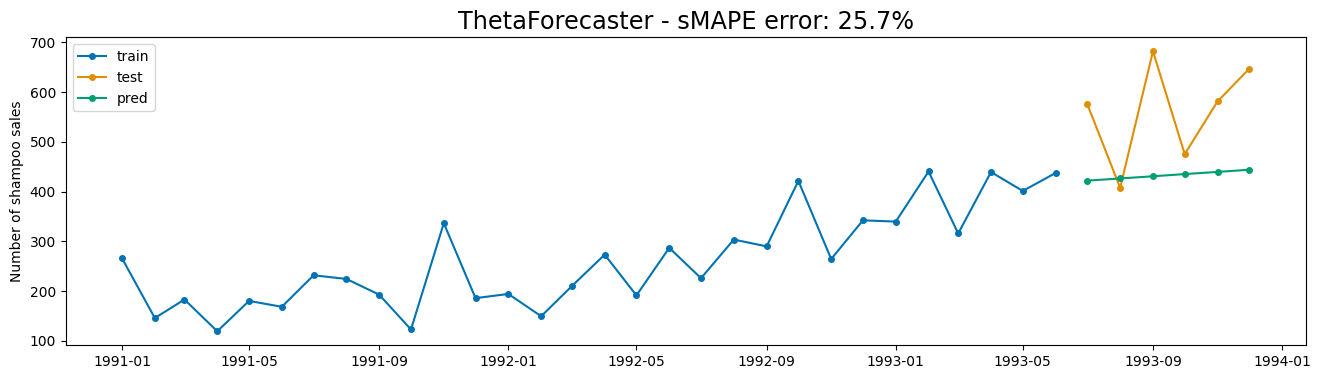

In [6]:
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.theta import ThetaForecaster

# 1) Define the model
forecasters = [AutoETS(auto=True), ThetaForecaster()]

for forecaster in forecasters:
    fh = [1, 2, 3, 4, 5, 6] # Relative to y_train
    # 2) + 3) we can also use fit_predict to combine fit and predict
    y_pred = forecaster.fit_predict(y=y_train, fh=fh)

    title = (
        f"{str(forecaster).split('(')[0]} - sMAPE error: {smape(y_test, y_pred):.1%}"
    )
    fig, ax = plot_series(
        y_train, y_test, y_pred, labels=["train", "test", "pred"], title=title
    )

Check out all other sktime forecasting algorithms [in the documentation](https://www.sktime.net/en/latest/api_reference/forecasting.html) or by running the code below:

In [7]:
from sktime.registry import all_estimators

all_estimators("forecaster", as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
3,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
94,VAR,<class 'sktime.forecasting.var.VAR'>
95,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
96,VARReduce,<class 'sktime.forecasting.var_reduce.VARReduce'>
97,VECM,<class 'sktime.forecasting.vecm.VECM'>


### Forecasting with ML algorithms (reduction)

- uses sklearn regressor on tabulated data to forecast
- plug & play any sklearn compatible regressor, e.g., lightgbm or xgboost
- important: forecasting != regression

Estimator does this internally:

![](./img/forecasting-to-regression-reduction.png)

in unified forecasting interface! No need to handle `sklearn` directly

In [8]:
# 1) Define the model
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction

# Can be swapped with XBGoost, LightGBM, CatBoost, etc.
regressor = HistGradientBoostingRegressor()

# Create a forecaster from the tabular regressor by wrapping it in `make_reduction`
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

# end definition

# visualize the composite forecaster - this looks just like the image!
forecaster

DirectTabularRegressionForecaster(estimator=HistGradientBoostingRegressor(),
                                  window_length=16)

y_pred          Number of shampoo sales
1993-07               296.222222
1993-08               323.888889
1993-09               327.100000
1993-10               350.800000
1993-11               361.655556
1993-12               378.044444


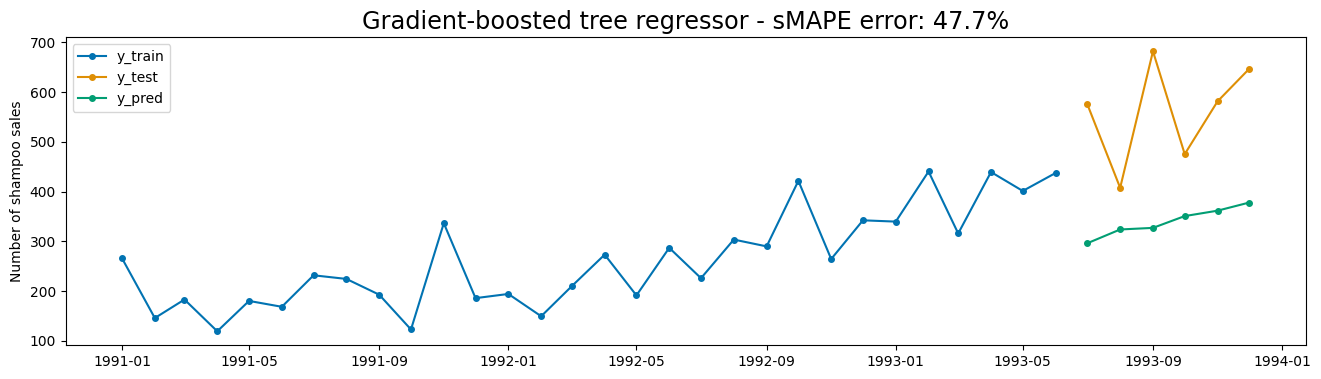

In [9]:
# 2) + 3) fit-forecast and plot - same as before
fh = [1, 2, 3, 4, 5, 6]
y_pred = forecaster.fit_predict(y=y_train, fh=fh)

title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

... the forecast is bad! Why?

Subtle:

- Gradient boosting trees cannot "extrapolate"
- only forecast well within their observed range

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformations = modular data transformation steps

(don't confuse with "transformers", a deep learning architecture)

Let's see how to use the `Differencer` transformer:

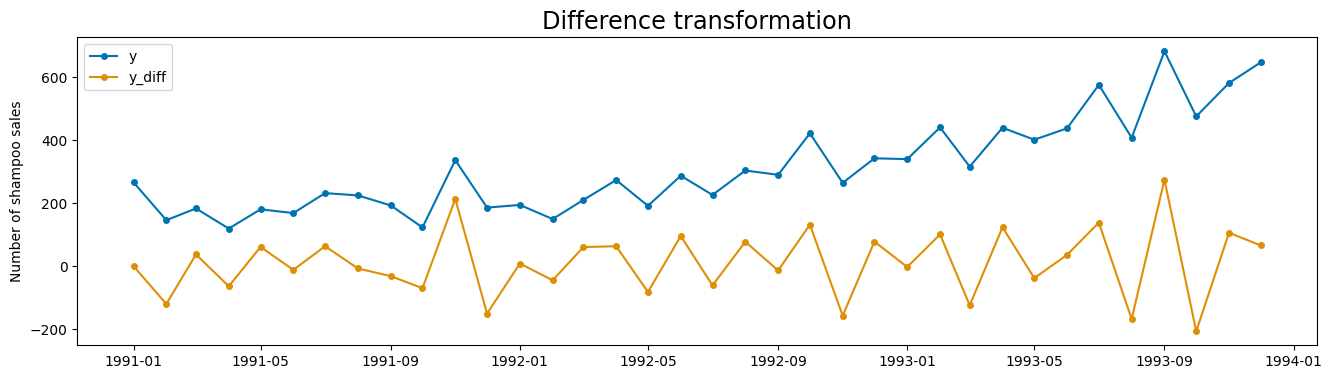

In [10]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

Transformers composable with forecasters, plug together to forecaster!

here: plug `Differencer` into tree-based reduction forecaster, via `*` dunder:

y_pred          Number of shampoo sales
1993-07                 7.377778
1993-08                27.666667
1993-09                 3.211111
1993-10                23.700000
1993-11                10.855556
1993-12                16.388889


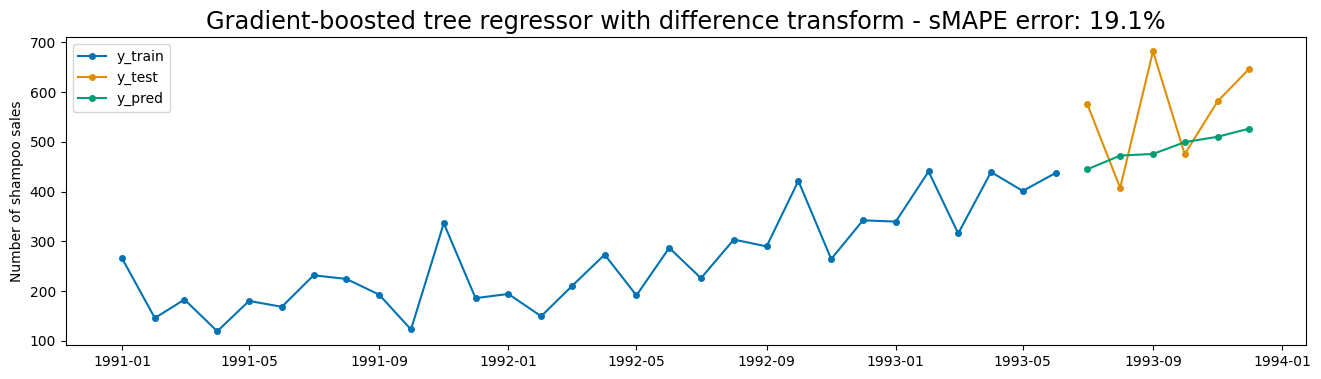

In [11]:
# 1) Define the model

# this is the reduction forecaster from before
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

# pipeline with differencer
# first difference, then forecast the differenced series, and finally invert the transformation
forecaster_with_differencer = Differencer(lags=1) * forecaster

# 2) + 3) fit-forecast and plot - same as before
y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)

# plot the forecast
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

More on transformers and composition later!

## 2.2 Univariate forecasting with exogenous data

- exogeneous data = other related time series that can improve prediction
- Example: information about promotions when forecasting sales (promotions drive sales)


We start by loading the same sales data we have been working on before.

In [12]:
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()

Let's use the sales data, noise and some simple transformations to create *fake* promotion

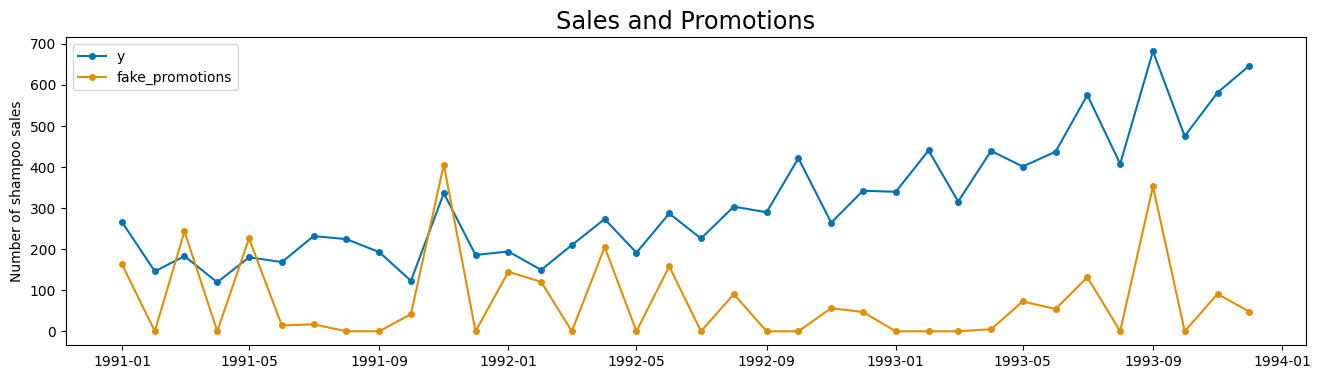

In [13]:
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer

# Use a differencer, clipping and some noise to generate fake promotional data
transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
noise = np.random.RandomState(seed=93).normal(0, 100, np.shape(y))
X_promo = (y_transform + noise).clip(lower=0)

fig, ax = plot_series(
    y, X_promo, labels=["y", "fake_promotions"], title="Sales and Promotions"
)

We can split both the target time series (y: sales) and the exogenous time series (X: promotions) with the `temporal_train_test_split` we have used before.

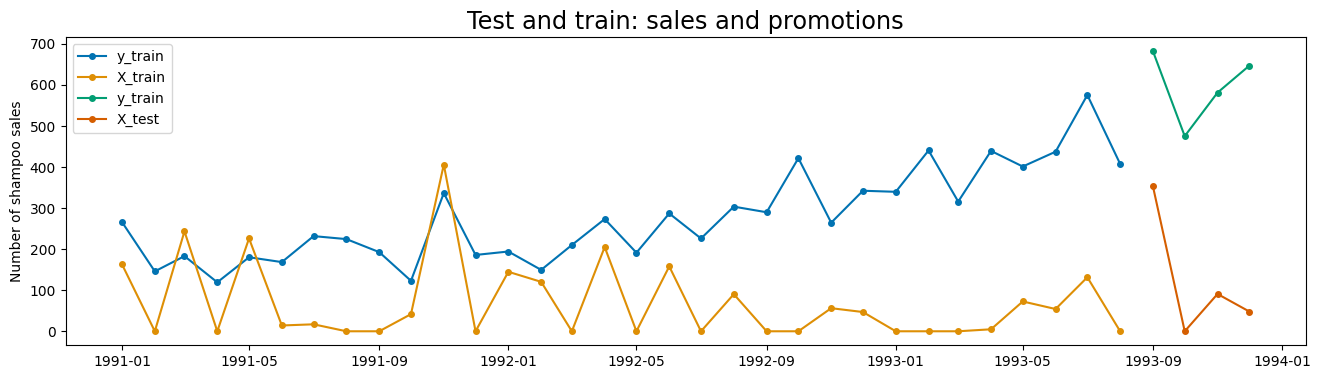

In [14]:
from sktime.forecasting.model_selection import temporal_train_test_split

fh = [1, 2, 3, 4]
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y, X=X_promo, test_size=len(fh)
)

fig, ax = plot_series(
    y_train,
    X_train,
    y_test,
    X_test,
    labels=["y_train", "X_train", "y_train", "X_test"],
    title="Test and train: sales and promotions",
)

Now we can forecast y (sales) also using the known values of future X (promotions) by passing the future X data in the predict step.

In [15]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(suppress_warnings=True)

# Use train data in fit
forecaster.fit(y=y_train, X=X_train, fh=fh)

# Note how the "future" data of X is passed in the predict step
y_pred = forecaster.predict(X=X_test)

Let's see how the prediction looks like when adding promotional data.

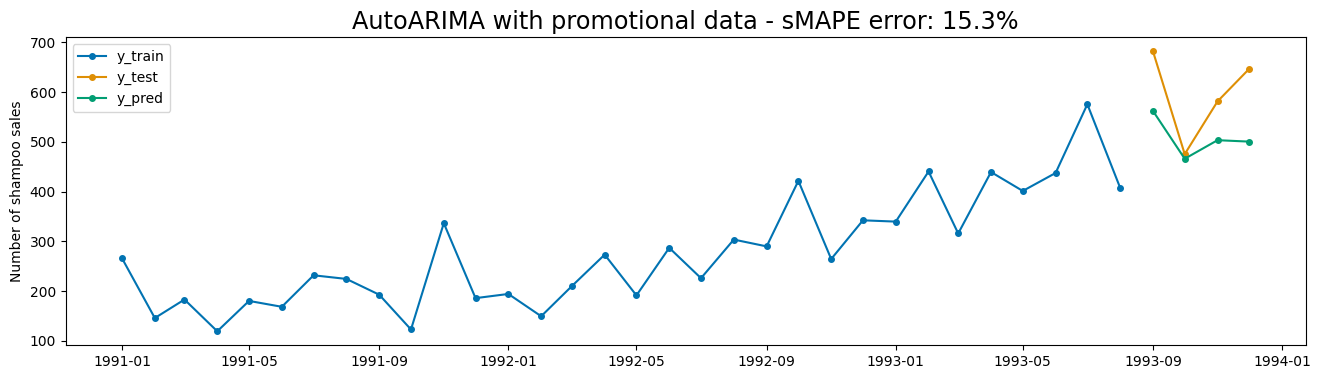

In [16]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

title = f"AutoARIMA with promotional data - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

Note: as we created the promotions from the sales data, the performance upflift is over-optimistic (data leakage).

But what if don't have future promotional data?

If we believe that we can forecast `X` (promotions) independently of `y` (sales) we can use these predictions of `X` to inform the predictions of `y`.

Here, we decide to use a different model for `X` than for `y`:
- y (sales): AutoARIMA
- X (promotion): Croston - due to intermittency


In [17]:
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.croston import Croston

forecaster_X = ForecastX(
    forecaster_y=AutoARIMA(suppress_warnings=True),
    forecaster_X=Croston(),
)
forecaster_X.fit(y=y, X=X_promo, fh=fh)

ForecastX(forecaster_X=Croston(),
          forecaster_y=AutoARIMA(suppress_warnings=True))

After fitting on both `X` and `y` we can creat predictions of `y` directly. Under the hood `sktime` is forecasting `X` with the `Croston()` model and using it in the prediction step of `y`.

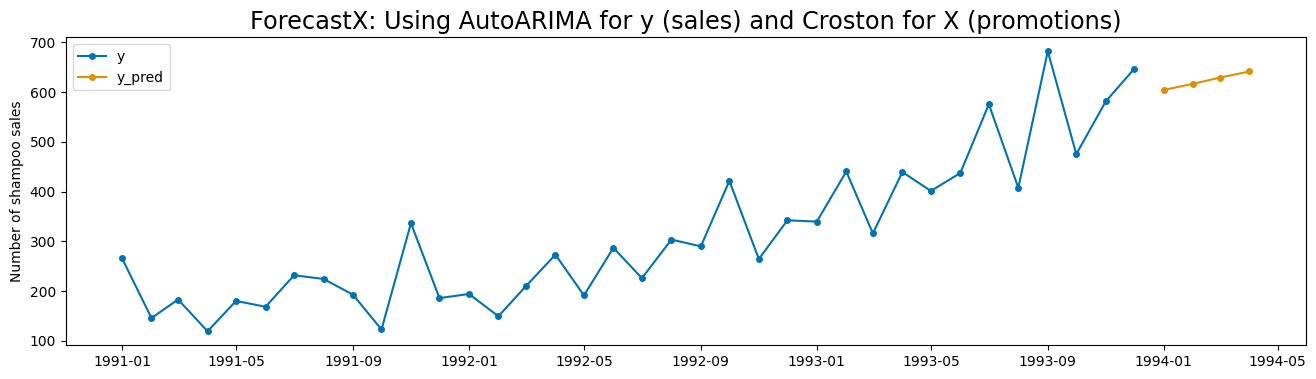

In [18]:
# Now in the `predict` step we don't need to pass X
y_pred = forecaster_X.predict(fh=fh)

title = f"ForecastX: Using AutoARIMA for y (sales) and Croston for X (promotions)"
fig, ax = plot_series(
    y, y_pred, labels=["y", "y_pred"], title=title
)

- Sometimes, the focus is not on a single univariate time series, but rather on forecasting a group of time series that represent different aspects of a single entity.
- Example: forecasting multiple macroeconomic indicators that collectively measure "the economy".

Let's explore how `sktime` enables multivariate forecasting for this use-case.

## 2.3 Multivariate forecasting

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [19]:
from sktime.datasets import load_longley

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

y

,GNPDEFL,GNP
Period,,
1947,83.0,234289.0
1948,88.5,259426.0
1949,88.2,258054.0
1950,89.5,284599.0
1951,96.2,328975.0
1952,98.1,346999.0
1953,99.0,365385.0
1954,100.0,363112.0
1955,101.2,397469.0


In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [20]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y, fh=[1, 2, 3])

y_pred = forecaster.predict()
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


We can inspects the tags of the `VAR()` forecasteer through to `get_tags` to check its multivariate nature.

In [21]:
forecaster.get_tags()

{'python_version': None,
 'python_dependencies': 'statsmodels',
 'env_marker': None,
 'authors': ['yogabonito',
  'ChadFulton',
  'bashtage',
  'josef-pkt',
  'thayeylolu',
  'aiwalter',
  'lbventura'],
 'maintainers': 'lbventura',
 'object_type': 'forecaster',
 'scitype:y': 'multivariate',
 'ignores-exogeneous-X': True,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': False,
 'handles-missing-data': False,
 'y_inner_mtype': 'pd.DataFrame',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'capability:categorical_in_X': False,
 'univariate-only': False}

But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using `ARIMA` which is a purely univariate model.

In [22]:
from sktime.datasets import load_longley
from sktime.forecasting.arima import ARIMA

_, y = load_longley()

y = y.drop(columns=["UNEMP", "ARMED", "POP"])

forecaster = ARIMA()
forecaster.fit(y, fh=[1, 2, 3])

forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ARIMA(),ARIMA()


As we can see `sktime` fits one single `ARIMA()` model per time series.

We can also check the nature of the `ARIMA()` model using the `get_tags`.

In [23]:
forecaster.get_tags()

{'python_version': None,
 'python_dependencies': ['pmdarima', 'numpy<2.0'],
 'env_marker': None,
 'authors': ['tgsmith61591',
  'charlesdrotar',
  'aaronreidsmith',
  'mloning',
  'hyang1996',
  'fkiraly',
  'ilkersigirci'],
 'maintainers': ['hyang1996'],
 'object_type': 'forecaster',
 'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:insample': True,
 'capability:pred_int': True,
 'capability:pred_int:insample': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'capability:categorical_in_X': False}

- Point predictions may not suffice in many forecasting scenarios.
- Even with the best models, forecasts inherently contain some level of uncertainty.
- This uncertainty can be expressed, by for example, providing prediction intervals.

`sktime` allows for straightforward generation of prediction intervals to capture forecast uncertainty.

## 2.4 Probabilistic forecasting

In [24]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_shampoo_sales()

y_train, y_test = temporal_train_test_split(y=y, test_size=6)

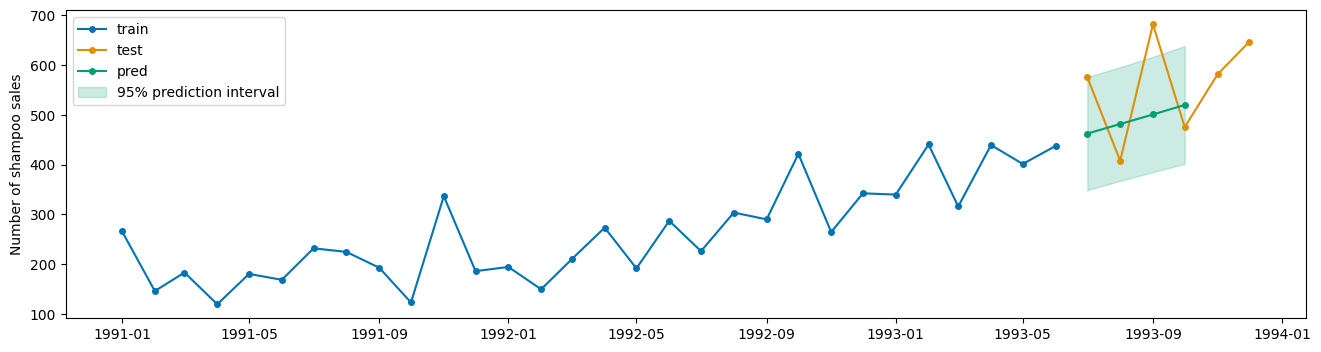

In [25]:
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting import plot_series

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4]
y_pred = forecaster.predict(fh)

# 4) Call a probabilistic method after or in place of step 3
y_pred_int = forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

We can check which estimators can perform probabiilistic forecasting by checking `all_stimators`.

In [26]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
    suppress_import_stdout=False,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
2,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
7,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
8,DartsLinearRegressionModel,<class 'sktime.forecasting.darts.DartsLinearRe...
9,DartsXGBModel,<class 'sktime.forecasting.darts.DartsXGBModel'>


Note:  estimators that have the `pred_int` tag always have all the probabilistic methods available. So estimators either have all of them or none.

Now let's look at the difference probabilistic methods and their different outputs.

In [27]:
forecaster.predict_interval(coverage=0.95)

Number of shampoo sales            
                           0.95            
                          lower       upper
1993-07              348.725151  575.969670
1993-08              367.230971  595.837225
1993-09              384.900391  616.541181
1993-10              401.437727  638.377220

In [28]:
forecaster.predict_quantiles(alpha=[0.275, 0.95])

Number of shampoo sales            
                          0.275       0.950
1993-07              427.694296  557.702217
1993-08              446.673329  577.460307
1993-09              465.397273  597.920326
1993-10              483.775947  619.330419

In [29]:
forecaster.predict_var()

,Number of shampoo sales
1993-07,3360.707082
1993-08,3401.105014
1993-09,3491.997328
1993-10,3653.580973


 `predict_proba` for full distribution forecasts

In [30]:
y_predict_proba = forecaster.predict_proba()

the prediction is an `skpro` distribution

*requires `skpro` installed*

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Number of shampoo sales'}, ylabel='1993-07'>,
        <Axes: ylabel='1993-08'>, <Axes: ylabel='1993-09'>,
        <Axes: ylabel='1993-10'>], dtype=object))

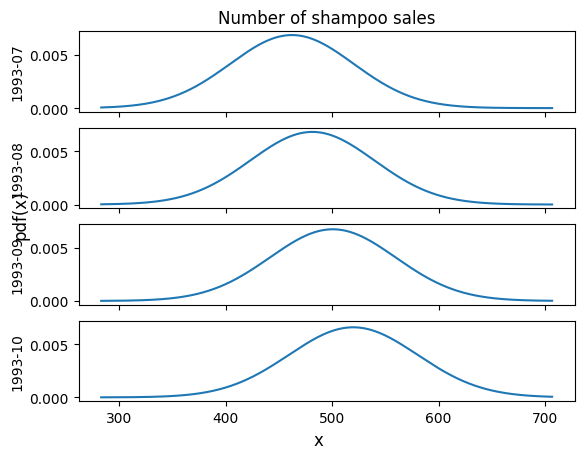

In [31]:
y_predict_proba.head().plot()

`skpro` distributions are 1st class citizens in the `sktime` ecosystem:

In [32]:
y_predict_proba

Normal(columns=Index(['Number of shampoo sales'], dtype='object'),
       index=PeriodIndex(['1993-07', '1993-08', '1993-09', '1993-10'], dtype='period[M]'),
       mu=         Number of shampoo sales
1993-07               462.347411
1993-08               481.534098
1993-09               500.720786
1993-10               519.907474,
       sigma=         Number of shampoo sales
1993-07                57.971606
1993-08                58.318994
1993-09                59.093124
1993-10                60.444859)

probabilistic metrics are available:

In [33]:
from sktime.performance_metrics.forecasting.probabilistic import CRPS

crps = CRPS()
crps(y_test, y_predict_proba)

72.28070279089647

probabilistic tabular regressors from `skpro` can be used in reduction!

y_pred          Number of shampoo sales
1993-07               -17.059370
1993-08               -18.905784
1993-09               -19.012199
1993-10               -11.451947
1993-11                -3.438361
1993-12                 2.941891
y_pred         Number of shampoo sales            
                          0.025       0.975
1993-07             -100.173712  113.145532
1993-08             -100.173712  101.741639
1993-09             -100.173712  101.741639
1993-10             -100.173712  101.741639
1993-11              -84.592955  101.741639
1993-12              -84.592955  101.741639


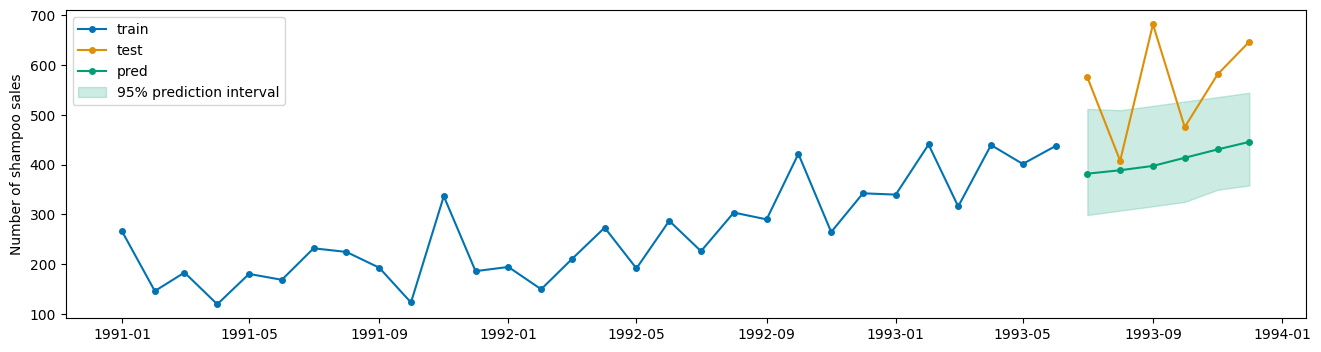

In [34]:
from skpro.regression.dummy import DummyProbaRegressor
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.detrend import Detrender

# 1) define the model
# detrend and then forecast empirical distribution obtained from sliding windows
# using direct reduction
proba_forecaster = Detrender() * make_reduction(DummyProbaRegressor(), strategy="direct")

# 2) Fit on train data
fh = [1, 2, 3, 4, 5, 6]
proba_forecaster.fit(y_train, fh=fh)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
y_pred = proba_forecaster.predict(fh)

# 4) Call a probabilistic method after or in place of step 3
y_pred_int = proba_forecaster.predict_interval(coverage=0.95)

fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["train", "test", "pred"], pred_interval=y_pred_int
)

y_pred         Number of shampoo sales           
                           0.25       0.75
1993-07              -64.131442   4.895476
1993-08              -64.131442   4.895476
1993-09              -64.131442   4.895476
1993-10              -64.131442   6.080126
1993-11              -48.346793  20.030070
1993-12              -47.823767  47.356989
y_pred          Number of shampoo sales
1993-07               -17.059370
1993-08               -18.905784
1993-09               -19.012199
1993-10               -11.451947
1993-11                -3.438361
1993-12                 2.941891


(<Figure size 640x480 with 6 Axes>,
 array([<Axes: title={'center': 'Number of shampoo sales'}, ylabel='1993-07'>,
        <Axes: ylabel='1993-08'>, <Axes: ylabel='1993-09'>,
        <Axes: ylabel='1993-10'>, <Axes: ylabel='1993-11'>,
        <Axes: ylabel='1993-12'>], dtype=object))

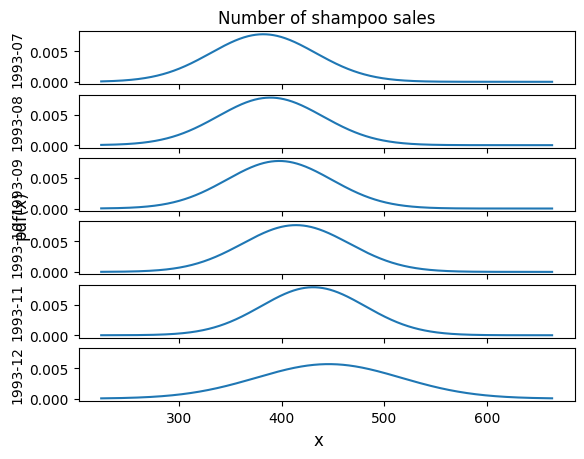

In [35]:
y_pred_distr = proba_forecaster.predict_proba()
y_pred_distr.plot()

More probabilistic forecasting features not shown here:

* wrappers to add forecast intervals or proba forecasts to any forecaster - `NaiveVariance`, `ConformalIntervals`
* automatic broadcasting across variables and hierarchy levels of probabilistic forecasts
* bootstrapping probabilistic forecasts, `BaggingForecaster`, `STLBootstrapTransformer`

## Hierarchical forecasting

![](./img/hierarchy.png)

Hierarchical dataframe of historical monthly sales (toy data):

In [ ]:
from sktime.datasets import load_hierarchical_sales_toydata
y = load_hierarchical_sales_toydata()

y

At specific date, sales are by hierarchy:

In [ ]:
# Multiindex slicing can become important when using hierarchical data!
y.loc[(slice(None), slice(None), "2000-01")]

visualizing the four sales time series in the hierarchy:

In [ ]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

`sktime` automatically broadcasts non-hierarchical models to hierarchical data.

In [ ]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True)

y_pred = forecaster.fit_predict(y, fh=[1])
y_pred

one forecaster is fitted per node series:

In [ ]:
forecaster.get_fitted_params("forecasters")

When working with hierarchies we often want to provide forecasts of the aggregated levels too.

Right now for this we would manually sum up the predictions for the lower levels that we are interested in.

A better way to do this is by using the `Aggregator` transformer in `sktime`.

In [ ]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y_hier = Aggregator().fit_transform(y)

y_hier.loc[(slice(None), slice(None), "2000-01")]

In [ ]:
forecaster = AutoETS(auto=True, random_state=0)

y_hier_pred = forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

If we compare the predictions at the top level with the sum of the bottom level forecast we can check that they are not the same!

In [ ]:
584.481241 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

This is because independent instances of each forecaster are fitted per level and there is currently no constrain to ensure the predictions add up.

In [ ]:
forecaster.forecasters_

We can use `ReconcilerForecaster` enfore hierarchical reconciliation to solve this problem.

The `ReconcilerForecaster` takes in a forecaster and add a reconciliation method.

In [ ]:
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler_forecaster = ReconcilerForecaster(
    forecaster=forecaster.clone(), method="bu"
)

y_hier_pred = reconciler_forecaster.fit_predict(y_hier, fh=1)
y_hier_pred

Now the top level and sum of the bottom level are the same.

575.259845 - (119.460419 + 169.749332 + 146.466778 + 139.583316)

We can retirieve the available reconciliation methods easily.

In [ ]:
print("Valid reconciliation methods:")
for method in ReconcilerForecaster.METHOD_LIST:
    print(f"- {method}")

We can also define different forecasters at different hierarchy levels (or hierarchy nodes) by using the `HierarchyEnsembleForecaster`. 

Forecasters built this way also aggregate the hierachical data for you under the hood.

In [ ]:
from sktime.datasets import load_hierarchical_sales_toydata
y = load_hierarchical_sales_toydata()

In [ ]:
from sktime.forecasting.compose import HierarchyEnsembleForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS

forecasters = [
    ('Auto ARIMA', AutoARIMA(), 0),
    ('Auto ETS', AutoETS(auto=True), 1)
]

forecaster = HierarchyEnsembleForecaster(
                forecasters=forecasters,
                by='level', default = AutoETS(auto=True)
)

y_pred = forecaster.fit_predict(y, fh=[1])

y_pred

Up to now, we have been always forecasting the hierachical data locally, but we can also leverage global forecasting:

- Local: fit a model to each time series locally
- Global: fit a single model to all the series

Benefits of global forecasting:
- The model has access to more data to learn from, great when individual time series are short.
- Faster than local approach
- Empirically shown to outperform local models (e.g. M5 forecasting competition)

Note: global models assume the data generating process for the group of time series is the same or at least similar.

In [ ]:
from sktime.datasets import load_hierarchical_sales_toydata
from sktime.forecasting.model_selection import temporal_train_test_split

y = load_hierarchical_sales_toydata()

y_train, y_test = temporal_train_test_split(y_hier, test_size=4)

y_test

Let's begin by using local forecasting with the gradient boosting regressor we used previously to forecast the hierarchical data.

In [ ]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

In [ ]:
forecaster.forecasters_

We can adapt the error metrics to a hierarchical setting by using `multilevel` argument to obtain scores for each level.

In [ ]:
hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
errors_local = hier_smape(y_test, y_pred)
errors_local

Now with the same regressor, we do global forecasting by setting the `pooling` argument to `global`.

In [ ]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")

y_pred = forecaster.fit_predict(y_train, fh=[1, 2, 3, 4])

Let's compare the scores for the `local` and `global` approach.

In [1]:
errors_global = hier_smape(y_test, y_pred)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")

NameError: name 'hier_smape' is not defined

### Recap

Quick recap of what we have covered in this notebook:

- Univariate forecasting (stats and ML)
- Univariate with exogenous data
- Multivariate forecasting
- Probabilistic forecasting
- Hierarchical forecasting

Also:

- Searching estimators via `all_estimators`
- Composing estimators from building blocks

### Next:

* hierarchical forecasting and tuning
* global forecasting and foundation models
* 2nd party library integration

### Credits: notebook - forecasting

notebook creation: marrov, fkiraly

partly based on:

* same notebook at ODSC and EuroPython 2023 workshops (fkiraly, marrov)
* pydata 2022 Berlin notebooks (fkiraly, danbartl)
* sktime forecasting tutorial (fkiraly, mloning and others)

sktime forecasting module: [many contributors](https://www.sktime.net/en/latest/about/contributors.html)